<a href="https://colab.research.google.com/github/xysu129/deep-learning-ust-2026/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW5

## Step 0: Import Libraries and Load Data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import imageio
from IPython.display import Image, display

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('single_cell.csv', index_col=0)
print(f'Data shape: {df.shape}')
df.head()

Saving single_cell.csv to single_cell.csv
Data shape: (100, 200)


,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene192,Gene193,Gene194,Gene195,Gene196,Gene197,Gene198,Gene199,Gene200,group
Cell1,5.992481,8.637750,9.148508,0.000000,9.749526,NaN,0.000000,4.704148,11.965938,8.347030,...,1.172069,2.861306,5.676206,7.064524,5.963797,6.387515,5.404645,5.811143,2.250973,Group1
Cell2,6.705927,8.459997,NaN,0.000000,9.613102,8.837886,NaN,4.354085,11.835529,7.964430,...,0.000000,NaN,NaN,NaN,6.281317,6.541257,5.940163,5.120309,1.607604,Group4
Cell3,7.630381,NaN,NaN,0.000000,9.486118,8.731500,NaN,NaN,12.026917,8.264788,...,0.000000,2.729572,NaN,8.092617,6.048260,6.878665,5.550450,5.957771,2.729572,Group4
Cell4,7.067631,8.952405,9.636137,2.034341,9.719746,7.529173,0.000000,NaN,12.129077,9.857736,...,3.039986,2.623069,5.877711,7.349105,NaN,6.471351,6.568682,5.877711,2.846535,Group3
Cell5,5.732078,8.842180,NaN,2.192864,10.138186,7.676739,0.777724,4.987332,12.140196,8.067137,...,NaN,NaN,5.111780,6.785379,5.567958,NaN,5.455013,5.770349,2.747472,Group1


## Step 1: Preprocess

In [3]:
# Separate features and labels
X = df.drop(columns=['group']).fillna(0).values
X = np.log1p(X)  # Log transform to reduce skew
X_scaled = StandardScaler().fit_transform(X)

# Encode group labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['group'])
group_names = le.classes_
num_classes = len(group_names)

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f'Features: {X_scaled.shape}, Classes: {group_names}')

Features: (100, 199), Classes: ['Group1' 'Group2' 'Group3' 'Group4']


## Step 2: Build Classifier with 2D Latent Layer

In [7]:
inputs = layers.Input(shape=(x_train.shape[1],))
x = layers.Dense(128, activation='relu')(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
latent = layers.Dense(2, activation='relu', name='latent')(x)
outputs = layers.Dense(num_classes, activation='softmax')(latent)

model = models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 199)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 2)              │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,998 (132.80 KB)

 Trainable params: 33,998 (132.80 KB)

 Non-trainable params: 0 (0.00 B)

## Step 3: Callback to Save Latent Embedding Every Training Step

In [8]:
os.makedirs('frames', exist_ok=True)
image_files = []

class EmbeddingCallback(callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.latent_model = None

    def on_train_begin(self, logs=None):
        self.latent_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer('latent').output
        )

    def on_epoch_end(self, epoch, logs=None):
        emb = self.latent_model.predict(X_scaled, verbose=0)

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(emb[:, 0], emb[:, 1], c=y_encoded,
                              cmap='tab10', s=40, alpha=0.8,
                              edgecolors='white', linewidth=0.5)
        handles = scatter.legend_elements()[0]
        plt.legend(handles, group_names, title='Group', loc='best')
        plt.title(f'Latent Space — Epoch {epoch + 1}')
        plt.xlabel('Latent Dim 1')
        plt.ylabel('Latent Dim 2')
        plt.grid(alpha=0.3)

        fname = f'frames/epoch_{epoch + 1:03d}.png'
        plt.savefig(fname, dpi=100, bbox_inches='tight')
        plt.close()
        image_files.append(fname)

## Step 4: Train

In [9]:
model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[EmbeddingCallback()],
    verbose=1
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.3345 - loss: 1.4654 - val_accuracy: 0.4000 - val_loss: 1.3512
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.3217 - loss: 1.3612 - val_accuracy: 0.4000 - val_loss: 1.3558
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5115 - loss: 1.2886 - val_accuracy: 0.5000 - val_loss: 1.3407
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.4873 - loss: 1.2399 - val_accuracy: 0.4500 - val_loss: 1.3111
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.5391 - loss: 1.1935 - val_accuracy: 0.4500 - val_loss: 1.2879
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.5247 - loss: 1.1491 - val_accuracy: 0.4000 - val_loss: 1.2757
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.5257 - loss: 1.0725 - val_accuracy: 0.4000 - val_loss: 1.2746
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.5049 - loss: 1.0400 - val_accuracy: 0.4000 - val_loss:

## Step 5: Compile GIF

/tmp/ipython-input-2544994781.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(f))


GIF saved: latent_evolution.gif


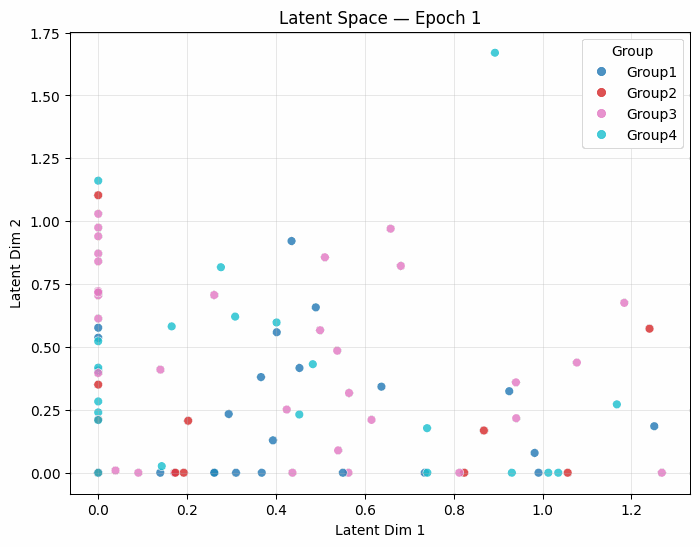

In [10]:
gif_path = 'latent_evolution.gif'
with imageio.get_writer(gif_path, mode='I', duration=0.3, loop=0) as writer:
    for f in image_files:
        writer.append_data(imageio.imread(f))

print(f'GIF saved: {gif_path}')
display(Image(filename=gif_path))